**Ejercicio 1:** Implemente el algoritmo de entrenamiento de un SOM bidimensional de forma que se pueda ver gráficamente el mapa topológico durante todo el proceso. Para poder observar el ordenamiento topológico, en el mapa grafique líneas de unión entre pares de neuronas vecinas. Realice las pruebas de ordenamiento topológico con los patrones provistos en los archivos circulo.csv y te.csv, usando un máximo de 1000 épocas de entrenamiento.

#### <b>Librerías</b>

In [51]:
import random
import csv
import numpy as np
import matplotlib.pyplot as plt
import time
import matplotlib.animation as animation

#### **Inicialización**

Determinamos la estructura de nuestro SOM, determinando *filas* y *columnas* de una matriz para el caso bidimensional (para este caso, hacemos 15x15 como mucho para simplificar). Si queremos un SOM unidimensional, seteamos *filas* = 1 y las *columnas* de la dimensión deseada.

Además, definimos el radio de vecindad a tener en cuenta con la variable *rv*. Por ejemplo: si *rv* = 1, entonces actualizamos los pesos de la neurona ganadora y de aquellas que entran en un rombo de radio 1. 

In [52]:
filas = 3       # Filas de neuronas
columnas = 3    # Columnas de neuronas
rv = 1          # Radio de vecindad

Levantamos los datos del archivo .csv e inicializamos al azar los pesos para todas las neuronas del SOM. Así, obtenemos una matriz de vectores de pesos tal que los índices [i,j] de la matriz me van a dar el índice para cada neurona dentro de mi arreglo bidimensional y me manejo con eso para las vecindades.

Otra alternativa para la inicialización de los pesos podría ser escoger al azar una entrada para cada neurona y asignarla como peso.

In [53]:
# Entradas desde el archivo .csv:
entradas = np.loadtxt('./data/te.csv',delimiter=',')
cant_entradas = len(entradas[0])

# Inicializo al azar los pesos:
W = np.empty([filas,columnas], dtype=object)
for i in range(filas):
    for j in range(columnas):
        W[i,j] = np.random.rand(cant_entradas)-0.5

print(W)    # Visualizo estructura de la matriz de vectores de peso.

[[array([-0.04760943,  0.35148349]) array([-0.32529243,  0.17744647])
  array([-0.47132545,  0.23688578])]
 [array([-0.42246642, -0.31284522]) array([ 0.30078628, -0.09865302])
  array([-0.05433063,  0.29709802])]
 [array([-0.48412068,  0.05148361]) array([ 0.13583906, -0.36488663])
  array([ 0.16121812, -0.27375752])]]


#### **Entrenamiento**

Para este caso, a modo de simplificación, los pesos serán actualizados teniendo en cuenta una distancia cuadrada (actualización es la misma para neurona ganadora y sus vecinas, en vez de usar una gaussiana o similares que actualizan en menor medida los pesos según la distancia a la ganadora).

In [54]:
mu = 0.01          # Velocidad de aprendizaje
epoca = 0
epoca_max = 50
W_saved = [np.copy(W)]

while epoca < epoca_max:

    for input in entradas:

        # Obtengo neurona ganadora buscando peso de menor distancia en W:
        min = float('inf')
        for i in range(len(W)):         # Por cada fila
            for j in range(len(W[0])):  # Por cada elemento de la fila
                dist = np.sum((input-W[i,j])**2)
                if dist < min:
                    min = dist
                    indice = (i,j)      # Índice de la neurona ganadora
        
        #dist = [[np.linalg.norm(input - w) for w in row] for row in W]
        #indice = np.unravel_index(np.argmin(dist),W.shape)

        # ACTUALIZACIONES
        error = input - W[indice]
        inc = mu*error
        W[indice] += inc
        
        # Actualización de los k vecinos:
        # Me tengo que fijar que no se me vaya a índices negativos o fuera de los límites de la matriz
        for k in range(1,rv+1):           
            d = indice[0] + k                 # Me desplazo una fila abajo
            if (d < filas):
                W[d,indice[1]] += inc
                for j in range(1,rv+1):       # En esa fila, voy a la izquierda
                    dL = indice[1] - j
                    if(dL > -1):
                        W[d,dL] += inc
                for j in range(1,rv+1):       # En esa fila, voy a la derecha
                    dR = indice[1] + j
                    if(dR < columnas):
                        W[d,dR] += inc
        
        for k in range(1,rv+1): 
            d = indice[0] - k                 # Me desplazo una fila arriba
            if (d > -1):
                W[d,indice[1]] += inc
                for j in range(1,rv+1):       # En esa fila, voy a la izquierda
                    dL = indice[1] - j
                    if(dL > -1):
                        W[d,dL] += inc
                for j in range(1,rv+1):       # En esa fila, voy a la derecha
                    dR = indice[1] + j
                    if(dR < columnas):
                        W[d,dR] += inc
    
    if(np.array_equal(W_saved[-1],W)):        # Si ya no se actualizan los pesos, corto.
        break
    W_saved.append(np.copy(W))

    epoca += 1

print('Finalizó en la época',epoca)

Finalizó en la época 50


#### **Animación**

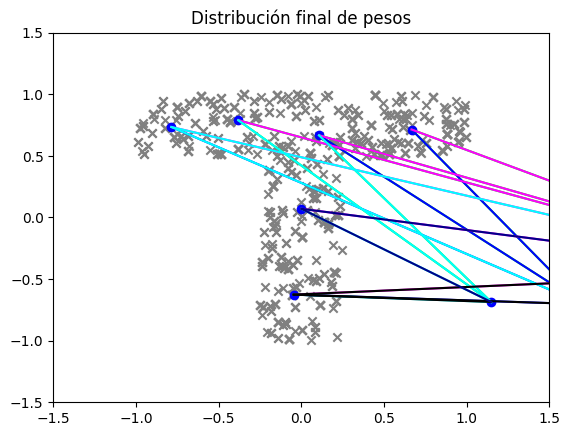

In [55]:
fig,ax = plt.subplots()

ax.set(xlim=[-1.5,1.5],ylim=[-1.5,1.5],title='Distribución final de pesos')
ax.scatter(entradas[:,0], entradas[:,1], marker='x', color='grey')  # Patrones de entrada

# Neuronas
x = np.array([[W[i, j][0] for j in range(columnas)] for i in range(filas)])
y = np.array([[W[i, j][1] for j in range(columnas)] for i in range(filas)])

ax.scatter(x.ravel(),y.ravel(),marker='o',color='blue')
hex_codes = []
with open('./data/hex-codes.txt', 'r') as file:     # Archivo con muchos colores porque puedo tener muchas neuronas
    for line in file:
        hex_code = line.strip()
        hex_codes.append(hex_code)

# Conexiones entre neuronas
for i in range(filas):   
    for j in range(columnas):
        c = hex_codes[(i*(j+2)+10)]           # Esto es para que tengan colores distintos pero siempre sean los mismos
        indice = [i,j]
        w1 = W[i,j]
        for k in range(1,rv+1):           
            d = indice[0] + k                 # Me desplazo una fila abajo
            if (d < filas):
                w2 = W[d,indice[1]]
                ax.plot([w1[0],w2[0]],[w1[1],w2[1]],color=c)
                for j in range(1,rv+1):       # En esa fila, voy a la izquierda
                    dL = indice[1] - j
                    if(dL > -1):
                        w2 = W[d,dL]
                        ax.plot([w1[0],w2[0]],[w1[1],w2[1]],color=c)
                for j in range(1,rv+1):       # En esa fila, voy a la derecha
                    dR = indice[1] + j
                    if(dR < columnas):
                        w2 = W[d,dR]
                        ax.plot([w1[0],w2[0]],[w1[1],w2[1]],color=c)
        
        for k in range(1,rv+1): 
            d = indice[0] - k                 # Me desplazo una fila arriba
            if (d > -1):
                w2 = W[d,indice[1]]
                ax.plot([w1[0],w2[0]],[w1[1],w2[1]],color=c)
                for j in range(1,rv+1):       # En esa fila, voy a la izquierda
                    dL = indice[1] - j
                    if(dL > -1):
                        w2 = W[d,dL]
                        ax.plot([w1[0],w2[0]],[w1[1],w2[1]],color=c)
                for j in range(1,rv+1):       # En esa fila, voy a la derecha
                    dR = indice[1] + j
                    if(dR < columnas):
                        w2 = W[d,dR]
                        ax.plot([w1[0],w2[0]],[w1[1],w2[1]],color=c)

plt.show()